Summary of my results:

model            | train_loss | valid_loss | seq2seq_acc | bleu
-------------------|----------|----------|----------|----------
seq2seq            | 3.355085 | 4.272877 | 0.382089 | 0.291899
\+ teacher forcing | 3.154585 |	4.022432 | 0.407792 | 0.310715
\+ attention       | 1.452292 | 3.420485 | 0.498205 | 0.413232
transformer        | 1.913152 | 2.349686 | 0.781749 | 0.612880

# Seq2Seq Translation with Attention

Attention is a technique that uses the output of our encoder: instead of discarding it entirely, we use it with our hidden state to pay attention to specific words in the input sentence for the predictions in the output sentence. Specifically, we compute attention weights, then add to the input of the decoder the linear combination of the output of the encoder, with those attention weights.

A nice illustration of attention comes from [this blog post](http://jalammar.github.io/illustrated-transformer/) by Jay Alammar (visualization originally from [Tensor2Tensor notebook](https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb)):

<img src="images/alammar-attention.png" alt="attention" style="width: 60%"/>

A second things that might help is to use a bidirectional model for the encoder. We set the `bidrectional` parameter to `True` for our GRU encoder, and double the number of inputs to the linear output layer of the encoder.

Also, we now need to set our hidden state:

```
hid = hid.view(2,self.n_layers, bs, self.n_hid).permute(1,2,0,3).contiguous()
hid = self.out_enc(self.hid_dp(hid).view(self.n_layers, bs, 2*self.n_hid))
```

### Code to re-run from start

In [1]:
from fastai.text import *

In [2]:
path = Config().data_path()

In [3]:
path = Config().data_path()/'giga-fren'

In [5]:
def seq2seq_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0])],res_y[i,:len(s[1])] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

In [6]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [7]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [8]:
data = load_data(path)

In [9]:
model_path = Config().model_path()

In [10]:
emb_enc = torch.load(model_path/'fr_emb.pth')
emb_dec = torch.load(model_path/'en_emb.pth')

In [11]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

In [12]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

In [13]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [14]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [15]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [16]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x,y,z in zip(xb,yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [17]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

In [18]:
class TeacherForcing(LearnerCallback):
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.pr_force = 1 - epoch/self.end_epoch

### Implementing attention

In [19]:
class Seq2SeqRNN_attn(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl,self.pr_force = nl,nh,out_sl,1
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.emb_enc,self.emb_dec = emb_enc,emb_dec
        self.emb_sz_enc,self.emb_sz_dec = emb_enc.embedding_dim,emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.emb_sz_enc, nh, num_layers=nl, dropout=0.25, 
                              batch_first=True, bidirectional=True)
        self.out_enc = nn.Linear(2*nh, self.emb_sz_dec, bias=False)
        
        self.gru_dec = nn.GRU(self.emb_sz_dec + 2*nh, self.emb_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.emb_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
        self.enc_att = nn.Linear(2*nh, self.emb_sz_dec, bias=False)
        self.hid_att = nn.Linear(self.emb_sz_dec, self.emb_sz_dec)
        self.V =  self.init_param(self.emb_sz_dec)
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, hid = self.gru_enc(emb, 2*h)
        
        pre_hid = hid.view(2, self.nl, bs, self.nh).permute(1,2,0,3).contiguous()
        pre_hid = pre_hid.view(self.nl, bs, 2*self.nh)
        hid = self.out_enc(pre_hid)
        return hid,enc_out
    
    def decoder(self, dec_inp, hid, enc_att, enc_out):
        hid_att = self.hid_att(hid[-1])
        # we have put enc_out and hid through linear layers
        u = torch.tanh(enc_att + hid_att[:,None])
        # we want to learn the importance of each time step
        attn_wgts = F.softmax(u @ self.V, 1)
        # weighted average of enc_out (which is the output at every time step)
        ctx = (attn_wgts[...,None] * enc_out).sum(1)
        emb = self.emb_dec(dec_inp)
        # concatenate decoder embedding with context (we could have just
        # used the hidden state that came out of the decoder, if we weren't
        # using attention)
        outp, hid = self.gru_dec(torch.cat([emb, ctx], 1)[:,None], hid)
        outp = self.out(self.out_drop(outp[:,0]))
        return hid, outp
        
    def show(self, nm,v):
        if False: print(f"{nm}={v[nm].shape}")
        
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        hid,enc_out = self.encoder(bs, inp)
#        self.show("hid",vars())
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        enc_att = self.enc_att(enc_out)
        
        res = []
        for i in range(self.out_sl):
            hid, outp = self.decoder(dec_inp, hid, enc_att, enc_out)
            res.append(outp)
            dec_inp = outp.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: continue
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)

    def initHidden(self, bs): return one_param(self).new_zeros(2*self.nl, bs, self.nh)
    def init_param(self, *sz): return nn.Parameter(torch.randn(sz)/math.sqrt(sz[0]))

```
hid=torch.Size([2, 64, 300])
dec_inp=torch.Size([64])
enc_att=torch.Size([64, 30, 300])
hid_att=torch.Size([64, 300])
u=torch.Size([64, 30, 300])
attn_wgts=torch.Size([64, 30])
enc_out=torch.Size([64, 30, 512])
ctx=torch.Size([64, 512])
emb=torch.Size([64, 300])
```

In [20]:
model = Seq2SeqRNN_attn(emb_enc, emb_dec, 256, 30)
learn = Learner(data, model, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))],
                callback_fns=partial(TeacherForcing, end_epoch=30))

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


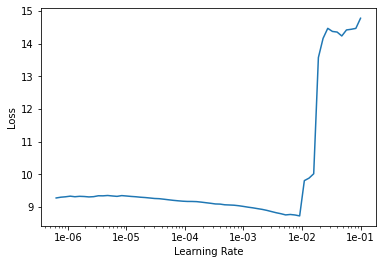

In [21]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,2.588181,4.035230,0.486399,0.278452,02:35
1,2.303889,3.285307,0.530429,0.282031,02:19
2,2.006488,3.305011,0.560996,0.357290,02:15
3,1.783360,3.778336,0.502589,0.398373,02:12
4,1.702023,4.115705,0.484794,0.415714,02:08


In [ ]:
import importlib
importlib.reload(fastai.text.data)
import fastai.text.data

In [53]:
inputs, targets, outputs = get_predictions(learn)

[   2   51  200  817   10  804   22    0   37 9168   15 1112   26   76   39 2172 8991   18  660   11   57  314   26
  261   19 2014   10   13  817    9][   2   24   20   12  166  127  768  162  185   46  264   40  139   21  149   16  410  494   17   16  252   10  749
   78   16  421 1408    9][   2   84   40   11   34   11   29  893  601   19   56   18   92   25  653   18  299   52   21  306   14 1482   17
 4372   10   13 1698    9][    2    33    14  6624  2302    11    34    11    29    19    12 10391  3378    12  5240     0    15    10  9579
  5950    30    12   472  1078    15  3052    25     0     9][   2   24  127   10 1160 2536 2113   20 4110   44 2171 4186   10   13   87   58  162  185   12 2171 4186   10   13
   87   23 1831   41    0   47    9]

[   2   33  679   11   34   11   43   48  761   14 2035  463   25  611   10   13 3020 1417   38  156   10   13 1583
   16  270    9][   2   33    0  406   76   10  697  573  592 2283  540 1497  305   18 1497 2551   10  935   19   13  

[   2   11 1309   30   23 1886   17   10 5295   12   10  291   13  214   18   54    0  166   17 2699  539    9]

[   2   11   43 1658 1658 2873   82 6101   66 7670   28   27  544   18   14  786   82   74  590   27  318 1942 3652
    9]

[   2   11   15   10  224   12  317  137   28   10 1588  952  151 1244   18   14   11  326   37   10  341  935   13
 2971 3461  151    9][   2   11  150   77   13   24  152   13  142  954   12  413   79 1895   18 1896   18  157   14  630    9][   2   11   15   10 2067   12   32  794   14   39  230  588   16 1855   13  907   10 2955   14   10  755  273    9]

[   2   33   14  219   10  238   17   13  161 1705   17 2945   40   11   34   11   29    0  713   12  270 2351   38
   54    9]
[   2   11   43   38  530    0   73  569   12   76 3532   36   24 1933   54 2605   18   14   73  569   36   24 1933
   54 2425    9][   2   11  113   12  382  558   27 7524   21  215 3304  574   33 4349   10  755  192   18   25  701   17    0   40
 2672 5842   12   19  215 

[   2   11   16   10  199   12  347  123  965   14  392  105   28   60  239   14 1569  408   27   99    9][   2   11   15   10  628   88   12   10   87 4442   28   87   17  156  743   20  381  196    9]
[   2   33   72 7527   57  436   16 1437   14  602   18   16   10    0  241  619    9]
[   2   26   61   19 2348    9][   2   11 5340  130   82 1035 1599   10 3483   12   57   13   10 3512   12   31  193  118   97   17   10   83  450
    9][    2    30    28   103    18    24    20    12   296    17    41   118    10  1417  7339   480    18    15    67
    99    11    50    62 10753     9]
[   2   33   61    0    0 2045   13   10 1562   58  340   70 5792    0   18 1081    9][   2   26 4208   10   78   12   46   68 4191   12  221   14  404  565    9][   2   22   29 1963   28 1385   18   39   15 3768   52   14 2116    0   47   17   86    0  270  196    9][   2   11   65  257   21   62   30   13  440   13   24  593   13  125   19 2020  126   10   72    0    9]


[    2    33    60    11   

   97  210    9][   2   11   44   10  552   24   20   10 1971  238  691 1826 1466  222   25  222 2413   28   77    9][   2   11  321   15   89   31   10 5280  348   30   69 1849  602   14 3187 1762   13 5280  615    9][   2   11  926   35   24  133   20   10 1611   27 3261  945   17  638    9][   2   33   36   10  264 3598   10 1225   12    0  124   55   10  300  465 1620   51 2298  724    9]
[   2   15   19   59  984   11   34   11   29  592  446   39 6367   10  751  192    0   37   45 2096   30   28  244
  202    9][   2   39   12   10  175 1375   17   46  211   10  708 2296  279   12 2275 5272   17  967    9]

[   2   41   16   10    0   18 3384   18 2702   14    0    9][  2  11  15  10 234 599  12 406  13  24 663  13  10 657  58 242  14  55  10   0 613   9]

[   2   27  250   60   14 1155   18   14  141 1032   18   14  176 1032   15   14  518   10  314   10  169   17  732
   36   13 1501   10   13   68    9][   2   51   12 4288 1070   16  564  528   21  852   39  342   18   67   12

    9][   2   11   81   35   10 5727  218   17  920   14  214   17  643   13   10 6574  182    9]


[   2   33 1544   23   40 7786  275   39    0   30   39 1125 3652   29   84   40 1332  278  153   11   29   39  676
 1666   21  755    0   10  377    9][   2   33   23  209  417    0   13   10  524  764  310 6498  281   23   34 2874   32  441 1893   28   83  524 4144
   25    0    9][    2    32    40    64    14   115    10  1005    26    96    10   160  2103    75    12   209  4757    10    90
   232    13   152    26   258    10 10557     9]



[   2   11   34   49  225   13   10  946   12   19  411    0    0  194   99 6488   55   19 1581 1545 4282   26   64
  749   69 2572   51 3558    9][   2   11   15  195   17  235   12  867   13  925 1115  609   13  218   19 1699   81   17   53  701   80 4936  654
  229    9]


[   2   11  217   34   24  152   13  142   31   83  111 2103   15  117   13  109 3038    9][   2   24  391   10  614   15   10  417   40   11   34   11   43  437   26  184

    49 10646  2643    45  3974    19   594  4987    38     0     9][   2   22   19   78   18 1465   29  250 1231   13 3383 1512   51   48 2361   48 2103    9]

[   2   39 2101  279   18 2367   18   97   25 1601 1039   82   24 4455   43   29  140   12  392   67   50 3668   25
 2824    9]




[   2   32  343   16  615 3405   10   46  264   22 3126   17   13  161   16  303   58   26 1258   38  156   16  209
  955  270   47    9][   2   22   21  169   23  402   10    0   31  194  669  174   70   31 3266   62  110   19  264    9][   2   11   21  145  818   12  168  199   17   10 4896   47  299   13   10  191  131 2153    9][   2   11  764 1311   15 1286   43   10  561  831   10  878  795 1218   52 4925  914   54   10  373  795 1218   47
    9]
[   2   14  103  361   18   65   11   28   23 1179 3203   58   15   33   47   38  115  455   16  431   30   46  176
   10 1021    9]
[   2   23  406 3007   19  974  133  425   38    0   11    0   18   38    0   37   44    0  441 3974   10  302   56
  

   42   16 6457    0  131 8225    9][   2   11  550   44   60   46   30   20 7217   14 2219   10  555   52  182   54   19    0   20   10 1699  112    9][   2   11   81   34   10  320  218   17 3861  146 1966   17   10  541   12   19  479  659    9][   2   11   45   10  783  170   13 3008   68  237  163   20  875   14  780   40 4223   54 2790  601 2298    9]
[   2   32   85   62   18  119   31   18   14 4637  970   25  611   16  598 2425   30   12  505  943  910   58 1068
   11 6008   47    9]

[   2   26  103   10  338   10 1816   26  156    0   18   23   40 4018   10  588   41  327   21   41  640 1088 1763
    9][   2   11   15   19  970  342   12  107   13  925 1731   18 2559   14 2438   14 3289   12  454   60  190   13  440
   59  241    9]
[   2   11   16   10 2825   20    0    0 1110   51    0  898    9]
[   2   39   15  553   19  399  842   20   75  723 2178 1493 1002  194 3395   53  466   27 2357  945    9]
[   2   24   20   12  213 1755  509  861 3410 1502  263 8281   18  119  

    36    12 10737  7623    10    28  3255     9]


[   2   35 1042   37   24   82 2591   10 5724   15 1027   25 3319  133   11   49   31  907   21  957   46 2219   10
    0    0    9][   2   11  597   21   23  101   44   30   69  248   33 1013  385   19  363  211 2676   19  284   14 1815  227    9]
[   2   11  150   77   13   24  415   17  135   13  142   89   15 1552  390   13 2061   71  391    9][   2   33   12 1946   10 3706   10 1114   20   11   50 5226   26 2602 1892  609 4822   39 2641   25 2334   45 2204
   16  632 1951    9]
[   2   22   61   29 1074   13  274   14   22   16  169   89  102  423   17  135   13  665   29    9][   2   11   15   53  972 3339   12 3725 2993   13  244 3046  168  202   17  381 1012  228    9][   2   11 3279   13   24   10 6427   47   12    0   10  436   14  306   94   54   13  338   10  156  171   52   31
   15   18   10  952  180   47    9][   2   35  256   84   11   40   11   34   11   29   75   73    0   17 8611   77  209 7501   10  122   15   73 

   21   52   12 7292    9][   2   33   12  188  308 3817   11   74   10   45   26   45   10 6407   12   82 1475   42 4852   10  883    0 1669
    9][   2   11   88   64   10 5276   58 1622  211   28  697   18 2305   56 6801   18  462   56  623  624 2742  624   14
 2559    9]

[    2    33    22    11    29   237    21    12   692  6394     0  2047    13   572    16 10445    10  4896    16
   160    30    81 10612     9][   2   11   15   10  105   12  872  608  156  485   78 1716   40  289   13   10 2898  745   54   19  114 6153    9]
[   2   11   44   24   10   88   28 7282   14  718   43   10 1870  297  848 2400   10   74   12 4194 1724 6272   17
 3863  184    9][   2   32   22   14   83  510   25  254 1743  182 1870  204    0   25  229   10   93 8302   10    0   15   10   13
    0 6737 5759    9][   2   11   91   43 1275   10  267 2826  618  518  170   40   10  394  335   12 3938   18 1275   54  997   17 3283
    9]

[   2   23  133   18   38 2829   10 3304   18 3962   12   92   26  

    9][   2   11  546  714    0   18 1031   18   17 1462   14   17 1125    0    9]
[   2   32   83   12  608 1238   11   50   30   13 5465   10   13 2119   25  191 1591   15   10    0   16  117   10
 5132    9]




[   2   11   30   69   10  136  137   17   32  192  204   10  601 1650  174   17   10  210   12  186  149    9]
[   2   11   35   24   10   81   12   10  533  710 2041   17   46   17 5048   14    0 1833  840  168   14   60  143
    9]

[   2   24  129 8796   12  400 2611   10   13  439   15   46  177   10  439   22   11   29 1232  731  480   21    0
   17   53 2151    9][   2   15   51  525 3714  146 2300 8050 3155   44  428  292 1263   10   53   82  263 6355   13  158   10   13  142
  617    9]
[   2   22   37  314   10 1676  183   13   10  175  392  303   10   48 2151 1042   12   57   48  608 1073  351  960
 2220   56  650    9][   2   32   40   64  931   25 6079   36   12  252   10   87   25  313   23 1334   48 6895   25  320   25 6079    9][  2  11  15  10 232  20  98  7

[   2   61   98   11   57  187   10  525  207   13  427   36   12 2989    0   17 2630   15   10 5318   38   54    9][   2   11   37   10   97 1728  343   95   20   10  201   13   57   14  495  285   14  615    9][   2   27  154 6189 7718   16  296   17 3835   16   82   15 6149   38  223   11   62   15   17   13  699  370   25
   54    9]


[   2   27   20   12  180 4240   18   36 1181   10  124  462   18   16 1416 3022   12  125 4171 2130   16 1128   15
   12 2182 1490    9][   2   30   35  173  398   11   31 3358   37  131   78   12 1214  423   26   28   23   40  633   38   76   10  220
 2317   36   16  815 3352    9][   2   26   28   32  692   82  110  442   20 3483   57   14    0  550   17  179   12   10  175  514   12   32  148
    9][   2   11  112 1426   25  733  732 1941   17   32  192   82   24   90   20   29  140   12  144  400 1042    9]
[   2  112   16 6745   20 8876  523   39 8526    0    0   18   14   54   69   89   11   29   48   17   53  227  548
   15  168   13  445 127

   163   323  6464   744  1329    17    41   862  7554     9][   2   11   15   10  212   79   10   84  186  149  182   14   10   84 1553   12  149   14 3785    9][   2   33  610 7491   19  319   18   11   16   10  155   31   75  571   73  252   42 2090   13  127  523  319    9][    2    70    13     0     0     0    11    34    11    49  2573    36    14  2550    16  6745  5053    10    13
 10671    58     0    47    26   221    10   163  6707     9][   2   24   20   12  317  213   21   13   68   18   15   10   32  141   10  285   11   52 1272 3147   11   56  139
   21   52  381   17   53  213    9]
[   2   41   34   38  127  166   45  328   14  312  257   17   10  192   38   36   24 4349    9][   2   33   16   10  434    0    0   12 2638   12   10 2099  613   13   24 3386   14   33   36   10  613  846   13
 1037    9]
[   2   17   23 3200   12 1845   10  145 6854   21  809   16  573    0   18 1251   17   16 1031   48 7925   10  145
   15  703   16 2156    9][   2   27  235 4144   15  

  931    9][   2   11   65  397   35   10  264 2767   17   19   83 3654 3115   84   72  555 2103    9][   2   22   16  257   20  972    0   14 6046  353    9][   2   32   22   14  454  399   25  312   10    0 1350   10 2782  491 2541   10 2277   17   13 3626   25 2782 1297
   13 3283   17 1015   54    9][   2   33   69   48 4211   17  100 4051   21   81  395   28   19   76   46   92   21  498   44  117 4914  394   25
 2345 1503   36 1454    9][   2   22   35   10 2700 2925   12  969   14 1371  875   24   53    0  271   12   10    0   12   19  284 6925    9]


[   2   11   88   37   19  849   27  279   84 2296   30   28   46   58 1844   54   19 2531   20  404    9][   2  333   19   76  159   90   21  666   19   53    0 5184   69 1291   48   40    0   12  784   15   12  333  541
   25   54    9]










[   2   41   37   10   60  128 2011   56 3765   17 1166 1693   13 1332 2329   14   60    9]
[   2   11   30   10  176   78   14 1001   56 2131  104   13    0   46   58  472   17   29  5

   18  506   18   80   47    9][   2   35  466   14 2829   25  254   25 2169   25   54 8523   11   34   11   29 1010   17 5230   10   13  248  233
   25   54    9]
[   2   11   16   10 1359   14    0   12 1677 5976   17  192 1580   14   11   34   24  104   70   19   97   14   71
  105   13  359 1677 5976    9][   2   22   15   42   17   46   58  450   13  600  899   97   17   10 2076    9]



[   2   22 1463 1747  174 7217   53 3866  363   33  301   25  447  208    0   13 1327    0  194    9]


[   2   11 1608  199 1185  603   25  869   18   63   10   46 3731   70 3009 1024   14  299  187   30    9][   2   17   24  127   10   82   10   68   98   11   57  171  514  112  631  516   44   82   10  583   21  305 2594
    9]



[   2   11    0   47   12   10 4160  280 1539  753   63   23  127   75   14   56   25  808  607   14   22    9][   2   11   43   10  759 2096   13  161   11   10 4326 1883 1356   13  325    0   25    0   17 1299    9]
[   2   26   34 2560    0    0   68    0   33  325

    9]


[   2   11   34   24  721   13   29 1056   13  106   42   80    0   13  443 1770  812   20   57   45 3276   17 1087
   14  437    9][   2   11   16   10 2335   27  191  222   14  122   12  617  131   14   10  199   12   59  222   14  122   28   60
    9]

[   2   11   34   49   21   54   83 2313   13  558   53  566   13  109  260   17  216   13  568   19  746 2297   20
  134 2544    9][   2    0   11   31  508   30   41  501  521   10  417   23 4601   17  287   14   93   16  612  379   19   25 9061
    9][   2   24  210  119   31   12  296   17   13  161   30  635   10   13  971  861 4195  381   12  168   15   12  317
 1829    9][   2 1262   31   18   24   20   12  166  296 1680 2871   17   13  152   26  184   37   38 1228   10   13 1005    0
    9]


[   2   11   43 1195   10   60   12 2166  821 2602   25 1314 1691   18  247   14    0  207   61   32  148    9][   2   11   37   32  764   97  941   43   32 5944  445    0 2392    9][   2   33  119   31    0  672   11   34   11  

    9]

[   2   11   34  446   21   13 4860   10    0   27  166   12   10  867   39   44  402   83  201   13 8130  103   14
 2175  633 2357    9]
[   2   27   79   20   26  184   21  393   12  707   16 1967   86    0   26   28   23  273   14  417   16 1395    0
    9]

[   2   11  217   18   43  102   18   30   23  152   18   17   10  500 1721 1002   13  474   32 6027 1624   28   10
 1329    9]

[   2   24   20   12  396   91   12   45  509   19    0   46  264   21  149   13  341   10  438  557   44  419   16
  749  696 1408    9][   2   11 4169  283   14 1495   20 3451   14    0   35   24 2109   18  787   20 1159   31   16  896   13 2037    9]
[   2   19   59  195   11   34   11   29  201   70   14 4050   16    0   15   14 2934 3955   20 5716   16 2151   17
   13  205  336    9][   2   11  553  172   13   24  104   13  142   29   57   36   24  117   20   19 5915  412   17   10  198  267  174
    9][    2    23   826    48    38   345    41   297   349   516    17    13     0    21  31

 9929  478    0    9]

[   2   11   91   17   10  451   12   19 2231   14   56   25 3803   56 3804  128    0    9][   2   11   30   49  104   13   86  682 2821   13  511   45  137  120   29   18   14   37   42  629    9][   2   17   46  255   18   84   40   11   34   11   29   16  196   25  109   86   16 1012   10  101   10  165   23
  108   62 2895    9][   2   11   18   43  102   18 1608  199   52  603   25  869   47  208   30 3996   51 3057    9]

[   2   32   22   14  193   10 6726   25   93   21   14 2782    0  241 6837   25  193    0   10   13 3626   25 2782
    9]

[   2   24   20   86   60   64   12  225  627   37   12  166  296  861   46  264  868    0   26 4570   26  258   41
  376   10  390  553    9][   2   32   22  931   16  871   10  320  418   15   25  115 3014   36  740   10   68   15   13 1501   10  223   11
   62    9][   2 3479  181  114   19   52   51   31   88  369 1612   17    0   46 1620   15   19   31 1753   84 2904   17  244
  216   10 1820   17   13    0    9]

   12 2739   17 5663    9][   2   11   16   10  383   14  800   12   48 4543   48  356 1245   20  157   40  146 1099    9]
[   2   11   16   10  349   13 2219  652   18   14  326   20 4407   59  349    9]
[   2   24 6494  980   59   20    0   12   45  619   18    0   15 6342   36   14  193   10   13  560   10 3325   26
   96   10   68    9][   2   27   20   12  591   37 1170   30   14  109   10  130   25  779   18  491   12    0    0 3015   10  579  115
    9]
[   2   33   40   11   34   11   43    0   13  890 8322   41 5810   10  152   26 1339   21   12 7190 1690   25    0
    0    9]
[   2   10   27  145 1252   11   34   11   43   36  931   16  160   26   96   10  391   10 1028   37   10   79 5841
   36  822   15   12  215    9]







[   2   11  185   16 1190   33 2007  168 1450   12  285   18  163   14   71 1054 1103   13  168 1450   12  348    9]
[   2   51 3707   10 4265   37 8922 1850  460  232  230   17 1265   25    0   21  228  408  211 3094  534   18  157
 4745 1351   16  23

   10   13 8858   10    0    9][   2   17   32  704   98   11   57  187   16   91   38  148   25  463   10  150 1894 4837   21   82 3733   58 6288
   47    9][   2  379   18   28  135 2431   17 1904  209  144  114   27   20   12  225  408   19    0    0 5639   16  288 5018
   30   13  279 1094   11  776    9]
[   2   11  217   35   24  152   13  106 1213   31   10  258  270  304 3096   66 1404  133  126   10 2707 1676    9][   2   11  576  606 2146   15  117   17  275   35   42   24  195   17   19  605    9][   2   46  805   37   46  432   22   11   49 5943   17  220   26  258 3043   14  109 2438   10  137   42 1651   10
  806    9][   2   11   15   10  115   20 2498 1054   14 2728  348   20  123  126 5528    9]
[   2   55   11   28   19  100 4420  257    0   36   13  181  162  185   31   31 2891   78   12  277   30   46  191
   10   93    9]
[   2   35 1024   22 1174   21  567   12  117   16  196   25 1738  238   25 6904   18   84  641   12 5171   10  288
    9]
[   2   33   36  109 2

[   2   11   91   43   10 3006   14   10 3496   16  365 2307 2128   18   51   10  394   18   25  173  196    9]
[   2   19  153   11   29 1340   44  303   23 6016  369   21   13 2008   51  264 1188   54   69  456  540   48 2773
 1266    9]


[   2   35 1453 2062   11   31 5551 1169   12    0   25  254   17  701   10   13  565   10   13  231  207 1222 1928
    9]

[   2   15   33   18   94  806   10   13 2355   18   60   11   50 2722 2300    0   16 4267    0   15   56   60   11
   50 3126  261 5946   10 1545    9]
[   2   11   36   23   21   13 1856   10  666   12  989  324   17  144  168   97  627   14  401    9]

[    2    32   153   931    16   448    36    46   585 10093    37    10   896    17  4731    16   410   203    58
   797  3674    18   797  6338    18  1991   797    47     9]
[   2   24  364   10   13  118   10 5390   60   64 1128   30   13  161   86  330   86  739   19   31   88 2407   30
   46  313    9]
[   2   11  137   35   24  133   13 1974   20   42   13   24  593   

    9][   2   32   22   14  454   26  799   15   26  174  782   10   13  152   26  184   16 5021  850   25  132   10  161
    9]
[   2  201   18  655   11   56   26  177   10   56  395   18   33   12  784   10  161   59    0   11   50   41    0
 1101    9][   2   35   22   13  373  377   19   31   88 3685   17   13  889   18  717   11   17   11  242   46  377 2961    9]



[   2   35 1453   22  152   26  184   42   12  853   21 3589 1671   17   13 6682   10   13  142 1086   15   10   13
  142  617    9]
[   2   33   10 1679 1089   13  406   19  910   18   37   31   95   19 1322   28   10  271   12   10  653 2343   12
 2834    9]

[   2   11   16   10   75   98  855  185   18    0   13  134   87   18 3072   51 1986   14  678   27    0    9]
[   2   30   35  173   14   90   40   11   34   11   29 4018 8141   16 4658 8484   44  179   16  384  308   15   17
  105  860    9]


[   2  112    0   69 1242   48 9807 4278 2388  322   22 1506 1932   18   61   12  554   99   11   50  140  330  162

 1478  351    9]


[   2   17   46  255   18   24   20   12  296   12   45  509   23 4168   13 1071  107 1977  757   16  123 2615   30
   13   73 3433   77    9][   2   24   20   12  282   15   12 2110  794   25  470 1188   23 5767   13  656   10 1260   37 5205  107 1471   30
   28  470    9]
[   2   11   16  400   17   46  154   13  579   13  144  108   14  916   10 4013  108  332   52    0   47    9][   2   35   22   46 1926  207   12  109   10 4045   10 1451   15   10 2230   26  556   78   12  615   15   12  113
   25    0   86 3316    9][   2   24   20   12 7277 6661   21   12  186   15   12  308   18 1269  642   14 2298 1503   15   17  324  230   16
  160 2103    9]


[   2   11   72  428  158   24 1169   13  482  157   58  954   18  346   10   65  690  619   17  730 1036   14   10
  659 2192    9]
[   2   22   21  414 4709   18 2847    0  109   18  925 1680   80 1738 2809    9]
[   2   24   20   12  944 6515   23   18   17   46  255   18  108   62 5843   30   14  128   10 1495   

   14  918    9][   2   26   58  282   13   30   19    0   12 3232 2239 2582    9]




[   2   15   51   57    0   19   13 1333  358  912   21  851   10 3549  207  848   10  150 2586   37 4390   16 1752
 5687   30    0    9][   2   24  753  446   11   34   11   29   75   12  433  892   17 3499   25  285   15  249  188   25  189  178   16
  421  368   15 1121    9][   2   22   21   23  272  380   19 2095 1079   33   38  530  204 2897  174   12  484    9]

[   2   11   15 1179   40 1168 6109 2514   20   10   46 2367   20  684    9]
[   2   67   12  227 6104 5930   38   54   99   11   50 2994   12 2110   10   52   81  434   21   14  130  407    9][   2   11   88   21   23  101   10  242   36   30   17 3117   14 1187   46    9]


[  2  41  35  10 176  78 755 100 404  17   0  13 844  10 777  83 287   9]
[   2   35   22   13  256   75   14 7141 2523   36   14  454   16  129   15   14 7141 2523   36   12  467   10  331
    9][   2   11   61   10  708 3473  105   12  214  881    9][   2   11  

    21   140    12   145    12    45  3352   531     9][   2   22   63   75    0  109  377 4905   10  797    9]
[   2   11   15   19    0  507 1177   17    0   14   11   15   53  972  105   12 1015  151   17  235   12 1681   18
 7330   14    0    9][   2   27    0   37 4450   12  179   10   46  432 1831   11   34   11   29 2238 1406   17 1048   10   53  435    9][    2    24    20    12   979    15   449     0 10532    42    12   252  8455    23  2040    62  6487    42    12
  1084    30    14  1518     9]
[   2   35  620    0   11   31   21  703   12  328  892   17   13  152   26  258  110  350   10 3526  137   10  525
    9]
[   2   11   37   42  110   13 2600  421   27   17   14    0 8090   14    0   27  704   40  165  587   54  408   54
  567  587    0    9]


[   2   11   16   32 2123   20  137   13 1185   10 1265   25   10  817  921   13  106  121   80  607   20   10  583
  395  112    9][   2   24  196   10   73   13  169   30   14  388   10  163  385   77  537   11   56 1055   

   25   93    9]
[   2   11   16   10   71   68 3204   31   35   24  248   17    0   97   25 5327   56    0  187    9][    2    32    22    14   193  1975  2204    10    46 10049    23    59     0    30    39   578  3255    37    23
     0    46   371    17    39   578  3255     9][   2   23   89 2131   12 1389   18   12  538 6425  379   19   12  524   10    0   15   10    0   23   60   64 2999
    9]
[   2   11  570   21   10  157   30   28  242  327   18   14   11  472   21   62  106   13   10  728   93   12   10
 2426    9]
[   2   11  187   12  392   21   23  244   13  246   40 1669   18   14   11  283   37   32  162   74   13  925 1196
  118   10   71    9][   2   84   40   11   34   11   29   16  344   18   16 8219   37  249  348   17  981  275   19   57 4578   28  722
    9]
[   2   19  337   11   31   25   83   16  143   23    0   12    0   30   13  152   26 2184   10    0 1436   38  318
   16  612    9][   2   11   16   10  261   12 1122 1143 1525 1798  222   28   10 2146   12

    9][   2   33   10 7010 5243   36   10 1877   79   10 2732 1199   14   10 2732 1665   24 5088    9]

[   2   23  826   48   64 3289   58 1480   47   44 8623   23   60  349  191   75    0   15    0   58   15   42   13
  557   47    9]





[   2   33   15  730  379  704   12 1131   50   48 2201  730   48  377   19  249   27 2346  472    9]


[   2  543   84   40  204   11 1676   18   12  736 4513   26  483  155 1903   40   47   16  117 7249   17  324  230
    9][   2   11   15   10  105   12  993   17  752  269  903   13   19 3433  200  269 1008  993    9][   2   19   66  383   52  924  623   18   49   23    0   17 2786   10 5935   18   42  116 1551  320 1277   18 4266
    0    9][   2   11   44   23 3262   13   24   10  450   12   32  162   25  273   12  427   17 1391   17   10  401   12   32
  971 1494    9][   2   22   15   42   31   49    0   94  569   28    0 2183   54   99   19 2550  135   51   10    0   25    0   28
    9]




[   2   27  737 3695   37 1996  794   10  692   18

    9][   2   26   15 1115   14   22   16 5181   14    0  226 1360   14    0 1360  195    9]

[   2   67    0   11   31   13 4465   16  839   10 1898 6307   42   41  903    0   18    0   16 6101  767   15   10
  549    9][   2   19  136   11   57   52   51   57 5715   14  658 1823  625 2578   17   13  199   37   51   14  658 1823   40
   64 3649    9][   2   11 1644   59    0 3238   51   10  145 5834 5181 1893    0   52    0   47  453   17   74    9]

[   2   33   12  871   10  753   78   12  517   60   11   50   45 2590  349  882   17  848   10   68   30   14  103
   16 1960   15   16 1829    9]

[  2  11  91  13 121  33  62  30  13 568  18  54  75  21 194 129  25 267 235   9]

[   2   11  202  425   35   42   74   18   73   44   59   24  891   18   14   13  527   44   42 1018  103    9]

[   2   41   34   38  127   57   20  483  580   18  549   18   25 2873 3092   46    9]

[   2   24   20   12  117   15   12  375  533   26   28   23  273   13  247  786   10   73  130  558   16 1067 

[   2   11  439   52 1764   14 1313   47  208   24 1550   51  922  877   14  428   40  144  780   28 1690  143    9]
[   2   35   22   46  377 2961   18  717   11   17   11  242   35   22   13  373  377   19   31   88 3685   17   13
  889    9]
[   2   27  433   13  231  133   11   49  149   38  156   10   13  829 6564   21 1047   13  205   16  143    0   30
   14  176   10   13  903    9][   2   11   57   21   23  101   15  607   17   10  145  971 3137   12   10 6495   28  932  627   57  130    9][   2   11   16   10  267  316  454  463   17   10 2672    0   12 1125 1755   18   14   73   16   62 2114   13   29
  140   12 1753    9]



[   2   46 1628   15   46  132  118   20   11   50 1159    0   16  144   10  417   16 3087  942   30  645  259   15
   10   13  118 8490    9]
[   2   10   27 1136   15  943 1252   11   34   11   43  321   38  148   10 1351   10 7253   44  154   18  736   15
  147    9]


[   2   24   60   64   12  123   25    0   36   12  113   10  599   10   13   87   

[   2   11 3597  448   79   32 1572  115   14  102   12   10 3384 7162   28   10   84 3384  456    9][   2   23   20   12    0   15   12    0   18   53  548   23  491   45  107 2480    0   16 3690    0   26 2367    0
    9][   2   41   37  129  846   13  123   25 1472   19   80 6230   14  891  322   13   60   14   60  141    9]
[   2  119   31   18  295   10  194   46  313 6498   11   34   11   29  321   18   42  103   18   17   13  137   16
  103    9][    2    51    13   913    22    51 10793    21    12     0     0  6376    18    67    66    11    43  6150    14
   115    10   913    16  5009     9][   2   11  360   37   10   46 1942   14 1532  395   74   13  835 3250    9]
[   2   19   59  195   11   34   11   29   51 1991  135   10   87  351  826   64 1870   26   28   23  273  452 2182
    9][   2   55   11   28   19   14  639   10   87  406 3538   15   27   20   12  225 1045   16  573 3427   36  544    9]
[   2   27 1323   18   41  297  898   26  184   18    0  100  547   37   31

   441  6001    17  4541    16 10998     9]


[   2   19  108   52   12  421   18  635   15   12  598   21 1216   12  198   26  135   78   14  338 1156   15   13
 1218 3080    9][   2   26  209 1499 1062    0   18 2212  422  865   18   14 5364   14 3523  515    9]


[   2   11  423   14  726   16   17  135   20    0  855  528   14 1866    9]
[   2   11   15   32  422   52   29 2207  435  559   17  643   13  180   14  422   28  547   47   13  307    9][   2   24   20   12  240   26   96   10   68   15   12  144   10   68   23 7996   14   45  949   30   12 9614    9][   2   11   88   44   10  131   17   10   84 2296   30   28   10 4352 3166   68 1596  236   29  342   43   10 1042
  339   61    0    9]

[   2   22   35  178   26    0   10  149   12  410   17   10   75    0  213   24 6131   54 1606   12  231  186  231
  149    9][   2   11   15   10  117  193   28 4086 3469   18 3048 3458   14   10  321 1289   28 1840  112  405   14   60    9][   2   11   15   32  105   12  315   25 4516  

   36  925  121   13    0    9][   2   11   16   10 4043   12   10    0   52  603   25  869   56  430   25 2222   47   14   36  100 3506   24  505
    9][   2   11  153   12 6429 2219  400  448  995   46   14   73   21   62 3810   55 2142    9][  2  11  61  10 115  90  13 713  10 146  14 191  77  20  10 730 269  57  71  14 373 348   9][   2   22  158   85  649   17  956  308 1426  699   50   13 2874   66 4261   13   93    9][  2  33  36  10  71  24 117  18 518  25 981   9]

[   2   27  362   20  201    0   36   12    0   16 3993   10   63    0   42  100  643 2885   16  362  910    9]
[   2   32  153  931   36   12  729   51   43   81  912   39  680  162  185   14  115   22 1506 1569   37 1506  808
    9][   2   11   15   10  151   13   60   43   59  153   12  543   16   50 4029  205   10  971 1843 1535    9][    2    23    40    14   403    10   986    13   121    36    12  1393    15    79    15    13   121    36  4470
    10 10402    15    25  1025     9]

[   2   40   32 2686   10  

   233     9][   2   65   11   28   19  387 7643   31 3215   36   12  277   23 5601 5141   37   26   60   64   12 1967    9][   2   17  668   10   70 6810   11   57  380   41  101   10 1880   38  342   10  150  950 1825    9][   2   11    0 2396 5976   17   46   58   60  141  128   14   11   16   10  261   12   59 2759   20 1301   58  193
 1544    9][   2   11  140   12 1296  123  103   63   32  162  244    9]
[   2   22   63   38  164   10 1102   48   10  647   56  738 2051   15  453    0   48    9][   2   39  349   21   23  272 8102   75   10  243 3295   12   10 1216  269   14   73   21   23  163   13 2609  121
    9][   2   42   32  178   10 9931    0   11   34   11   43 1507   16 1512   17  498 2047   44  240   16  547    9][   2   12  692  155   59 1119   12  144  545  114   35  153 2561   16 1827  759   17  324  230    9]

[    2    24    20    12   196  3239    37 10134    23  1106    37     0    13  1071    16   102    10    13 10258
     9]


[   2   35   22   13  422   16  29

[   2   35   22 5867    0  814   42   12  743  578  182   30   12   92 1672   15   12   92 2393   36   12 2099    9][   2   19   59  984   11   34   11   29   51   31  398    0   42   13    0  275   19   31  398 5433    9][   2   22   37  169   10 5206  600   80  399   27 8035 5215  190    9]




[   2   19 5180   11   31   17  170  882   26   28   23  273   14 1518  190  487   21 3800 5366    9]
[   2   24  127    0   60   64  447   21  499   15 1253   12  213  550   17   13 1071   16  117   25 7658    9]
[   2   11   16   10  261   12 3644  280  230  257   20   10   60  128   54   19  789    9][   2   22 2244 6254  409  286  143   51    0  409  286  143    9][   2   11   45  103  379  126   10  249   27 4578   60  122   52 3910   47   71    9][   2   11   43   89   16  267   12  177 2593   10 3109   18   37   76  678   27 4632  813  125  704  761    9]

[   2  412   12  428  712   10  165   18   24   20  310   23 2363 3026   44  240 2651   15   44 3870    9]


[   2 1978 4557   25   

[   2   11   16   10  303 1275 5586    0  611   14 1084  150   20 2936   17 1080   14    0 5495 2577    9]
[  2  33  14   0  22  11  29  17  13 297 976 808  15 652  14 189  30  53 209 830   9]
[   2   24   20   12  266 1564   21   39 4503 1185  723   17    0   13 1324   10    0   30 9894    0 5041  762    9][   2   11   15   10 2929   52 3358 2467   51    0  339   47   12 2836 1865   17 2305    9]
[   2   27   20   12  362   16  800   26    0   15  249  796   26   96   10 2788   16  145 1608    9]

[   2   11   15   10   88   12   10 2188   12  309   36   28   10  259 4936   14   28   10 2464   40  510 1326    9][   2   11   37   29   95   20   10  555   18   10  592    0   12 2454   14   57    9]
[   2   32  115   10 1778 2991   11   31 1003  232    0   30   28   95    0   15   10  915   28   72   10  161    9][   2   10   35  481   28   72   66   11   29   62 3682   10  181   17   14  559   45  824    9][  2  11 546  33  23 816  96  12  59 427  17 774   9][   2   27   60   64   12  4

  215  214    9]

[   2   11  122   36 3038 1517   51   10    0   12 1491   14 1262    9]
[   2   11   16   10  614   18   14   11  369   37   10 1147   12  368   30   20   76  411   68  134    9][   2   11  113   12 1609   15  282   28  291  167   17 2197  409 4254    9][   2  457   11   34   11   29   70   39 2928   10 3138 1787   45 1759   18   45 6047   15   45    0    9]
[   2   32 1179   62  931 2146   11  370   14   45 2588   16 2262   30   14   92   37   13  363   17 1610    9]

[   2   11   82   24  104   13 1692   23   17  732  390  241    9][   2   11   64   69   10   88   12  166   27   12   27  269    0   28 2993   17  583 1036    9]

[   2   35  377   88   11   31 3685   26  507  191   17   13  889   30   46 3301   15 4765   11   31  426    9]
[   2  412   12 1556  423   18  357  459   48 1231   94 4230   39  206   10 1684   10 4588  886    9][   2   67 4765   31   14 2050   10  360  118 1169   14  801   21   12  113   16   46  572  752    9]
[   2   11   61   10  119 105

In [147]:
inputs[700], targets[700], outputs[700]

(Text xxbos qui a le pouvoir de modifier le règlement sur les poids et mesures et le règlement sur l'inspection de l'électricité et du gaz ?,
 Text xxbos who has the authority to change the electricity and gas inspection regulations and the weights and measures regulations ?,
 Text xxbos what do we regulations and and regulations ? ?)

In [148]:
inputs[701], targets[701], outputs[701]

(Text xxbos ´ ` ou sont xxunk leurs grandes convictions en ce qui a trait a la ` ` ´ transparence et a la responsabilite ?,
 Text xxbos what happened to their great xxunk about transparency and accountability ?,
 Text xxbos what are the and and and and and and and and and to to ? ?)

In [149]:
inputs[4002], targets[4002], outputs[4002]

(Text xxbos quelles ressources votre communauté possède - t - elle qui favoriseraient la guérison ?,
 Text xxbos what resources exist in your community that would promote recovery ?,
 Text xxbos what resources would your community community community community community community ?)